In [12]:
import torch
import sacrebleu
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze
from transformers import AutoTokenizer, AutoModel
from matplotlib import pyplot as plt

In [2]:
bugfix_files = pd.read_csv('bugfix_commit_files.csv', escapechar='\\')
bugfix_files.fillna('', inplace=True)

In [3]:
bugfix_files.head()

,Hash,Message,Filename,Source Code (Before),Source Code (current),Diff,LLM Inference,Rectified Message
0,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,constants.py,import os\nimport numpy as np\n\n\nGENERALLY_B...,import os\nimport numpy as np\n\nPRODUCTION_QU...,"@@ -1,9 +1,6 @@\n import os\n import numpy as ...",add more examples to the example,A few fixes to initial point_thickness impleme...
1,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,displayer.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -55,7 +55,7 @@ def paint_mobjects(mobjects,...",add nudge to the thickness calculation,A few fixes to initial point_thickness impleme...
2,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,mobject.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -21,7 +21,7 @@ class Mobject(object):\n ...",add missing docstring,Update configuration inheritance in Mobject cl...
3,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",animation.py,from PIL import Image\nfrom colour import Colo...,from PIL import Image\nfrom colour import Colo...,"@@ -4,7 +4,6 @@ import numpy as np\n import wa...",add missing code in animation,Update starting_mobject initialization in Anim...
4,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",meta_animations.py,import numpy as np\nimport itertools as it\nfr...,import numpy as np\nimport itertools as it\n\n...,"@@ -1,6 +1,5 @@\n import numpy as np\n import ...",add missing import,add missing import


In [4]:
pd.Series({
	"Total files": len(bugfix_files),
	"Total Bugfix Commits": bugfix_files['Hash'].nunique(),
	"Average number of files changed per commit": bugfix_files.groupby('Hash').size().mean()
})

Total files                                   1432.000000
Total Bugfix Commits                           838.000000
Average number of files changed per commit       1.708831
dtype: float64

<Axes: title={'center': 'Top 5 Most Frequent commit types'}, xlabel='Word'>

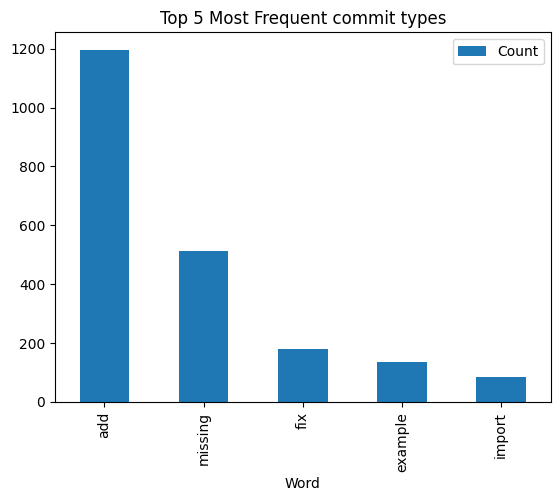

In [5]:
word_count = {}

for index, row in bugfix_files.iterrows():
    for word in row['LLM Inference'].split():
        word = word.lower()
        word_count[word] = word_count.get(word, 0) + 1

# Sort the word count dictionary by values in descending order and get top 5
# Filter out 'to' and 'the' from word_count before sorting
filtered_word_count = {word: count for word, count in word_count.items() if word not in ['to', 'the', 'more', 'for', 'in', 'scene']}
top_5_words = sorted(filtered_word_count.items(), key=lambda x: x[1], reverse=True)[:5]

# Create a DataFrame for plotting
top_5_df = pd.DataFrame(top_5_words, columns=['Word', 'Count'])

# Plot the top 5 words
top_5_df.plot(x='Word', y='Count', kind='bar', title='Top 5 Most Frequent commit types')
# plt.yscale('log')

In [6]:
top_5_df

,Word,Count
0,add,1196
1,missing,514
2,fix,178
3,example,135
4,import,85


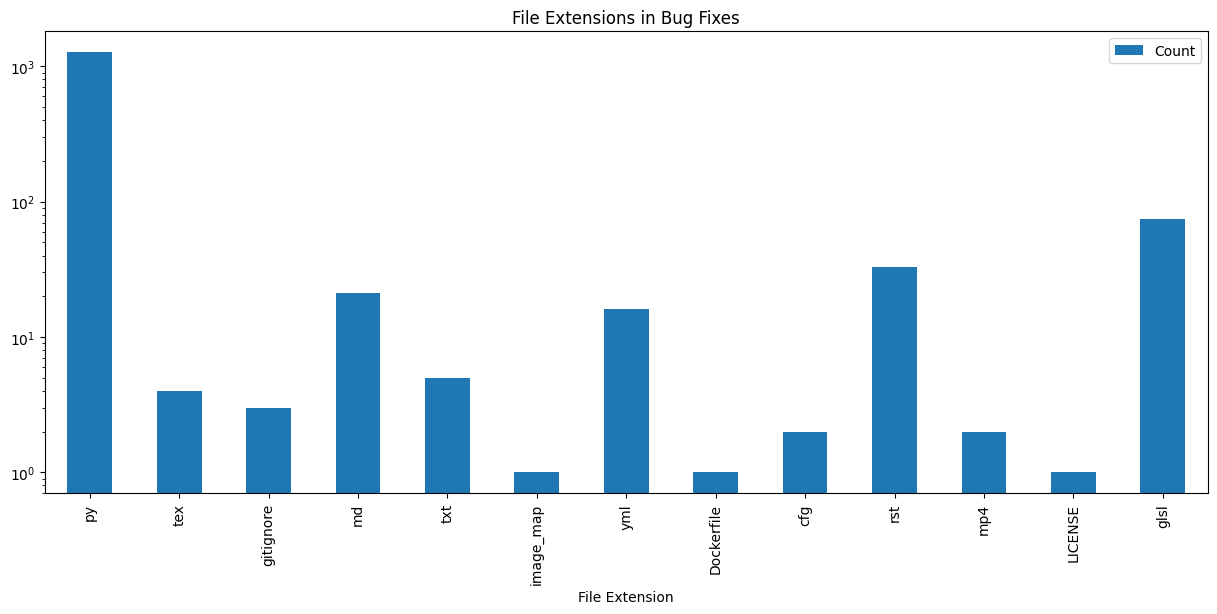

In [7]:
file_extension_counts = {}

for index, row in bugfix_files.iterrows():
    file_extension = row['Filename'].split('.')[-1]
    file_extension_counts[file_extension] = file_extension_counts.get(file_extension, 0) + 1

# Create a DataFrame for plotting
file_extension_df = pd.DataFrame(file_extension_counts.items(), columns=['File Extension', 'Count'])

# Plot the file extensions
file_extension_df.plot(x='File Extension', y='Count', kind='bar', title='File Extensions in Bug Fixes', figsize=(15, 6))
plt.yscale('log')

In [8]:
def compute_metrics(code):
	try:
		cc = sum(block.complexity for block in cc_visit(code))
		mi = mi_visit(code, True)
		loc = analyze(code).loc
		return cc, mi, loc
	except Exception as e:
		# print(f"Error computing metrics: {e}")
		return 0, 0, 0

for index, row in tqdm(bugfix_files.iterrows(), total=len(bugfix_files)):
	cc_before, mi_before, loc_before = compute_metrics(bugfix_files.at[index, 'Source Code (Before)'])
	cc_after, mi_after, loc_after = compute_metrics(bugfix_files.at[index, 'Source Code (current)'])
	bugfix_files.at[index, 'MI_Change'] = mi_after - mi_before
	bugfix_files.at[index, 'CC_Change'] = cc_after - cc_before
	bugfix_files.at[index, 'LOC_Change'] = loc_after - loc_before

100%|██████████| 1432/1432 [03:02<00:00,  7.83it/s]


In [9]:
bugfix_files.to_csv("bugfix_commit_files_MI_CC_LOC_Added.csv")

In [10]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base").cuda()

def cosine_similarity(a, b):
    return (a * b).sum() / (np.linalg.norm(a) * np.linalg.norm(b))

for index, row in tqdm(bugfix_files.iterrows(), total=len(bugfix_files)):
    before = tokenizer("<s>" + row['Source Code (Before)'] + "</s>", return_tensors="pt", padding=True, truncation=True).to(model.device)
    after = tokenizer("<s>" + row['Source Code (current)'] + "</s>", return_tensors="pt", padding=True, truncation=True).to(model.device)
    # if (index >= 15):
    #     break
    with torch.no_grad():
        before_emb = model(**before).last_hidden_state.mean(dim=1).cpu().numpy()
        after_emb = model(**after).last_hidden_state.mean(dim=1).cpu().numpy()
    bugfix_files.at[index, 'Semantic_Similarity'] = cosine_similarity(before_emb, after_emb)
    bugfix_files.at[index, 'Token_Similarity'] = sacrebleu.corpus_bleu([row['Source Code (current)']], [[row['Source Code (Before)']]]).score / 100.0

100%|██████████| 1432/1432 [03:11<00:00,  7.47it/s]


In [11]:
bugfix_files.head()

,Hash,Message,Filename,Source Code (Before),Source Code (current),Diff,LLM Inference,Rectified Message,MI_Change,CC_Change,LOC_Change,Semantic_Similarity,Token_Similarity
0,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,constants.py,import os\nimport numpy as np\n\n\nGENERALLY_B...,import os\nimport numpy as np\n\nPRODUCTION_QU...,"@@ -1,9 +1,6 @@\n import os\n import numpy as ...",add more examples to the example,A few fixes to initial point_thickness impleme...,0.000000,0.0,-1.0,0.999902,0.988357
1,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,displayer.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -55,7 +55,7 @@ def paint_mobjects(mobjects,...",add nudge to the thickness calculation,A few fixes to initial point_thickness impleme...,0.000000,0.0,0.0,1.000000,0.951255
2,014a277a97759bbc0e6ec8fba588bc6e6de65a86,A few fixes to initial point_thickness impleme...,mobject.py,import numpy as np\nimport itertools as it\nim...,import numpy as np\nimport itertools as it\nim...,"@@ -21,7 +21,7 @@ class Mobject(object):\n ...",add missing docstring,Update configuration inheritance in Mobject cl...,0.000000,0.0,0.0,0.999808,0.997525
3,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",animation.py,from PIL import Image\nfrom colour import Colo...,from PIL import Image\nfrom colour import Colo...,"@@ -4,7 +4,6 @@ import numpy as np\n import wa...",add missing code in animation,Update starting_mobject initialization in Anim...,0.225313,0.0,-1.0,0.999607,0.987431
4,ac930952f151acf284f6e01e98e8f7256f29f9f4,"Beginning transform KA article, many small fix...",meta_animations.py,import numpy as np\nimport itertools as it\nfr...,import numpy as np\nimport itertools as it\n\n...,"@@ -1,6 +1,5 @@\n import numpy as np\n import ...",add missing import,add missing import,0.268985,0.0,-1.0,0.999841,0.994031


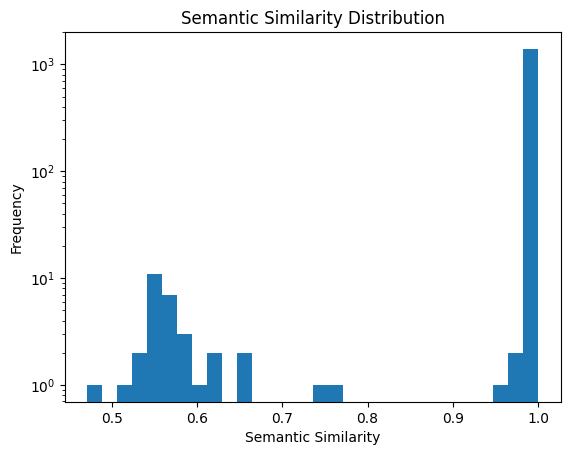

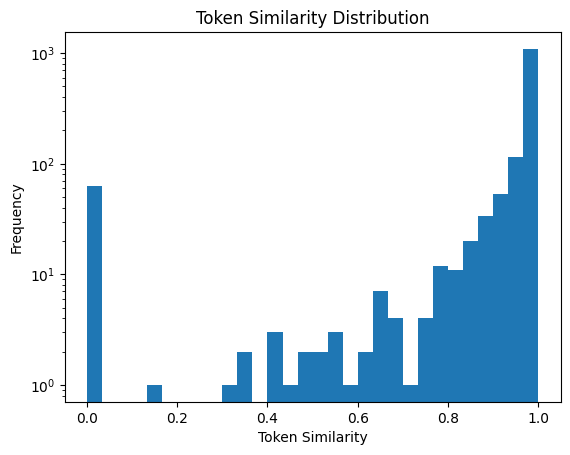

In [16]:
plt.hist(bugfix_files['Semantic_Similarity'], bins=30)
plt.title('Semantic Similarity Distribution')
plt.xlabel('Semantic Similarity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()
plt.hist(bugfix_files['Token_Similarity'], bins=30)
plt.title('Token Similarity Distribution')
plt.xlabel('Token Similarity')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

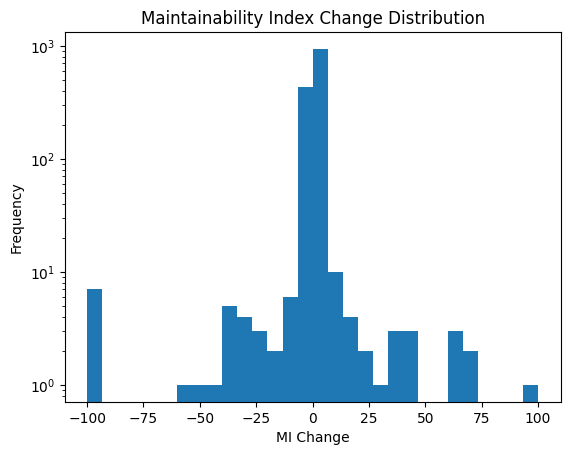

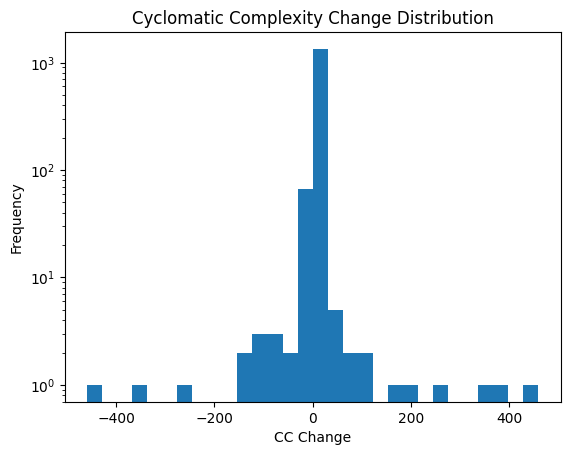

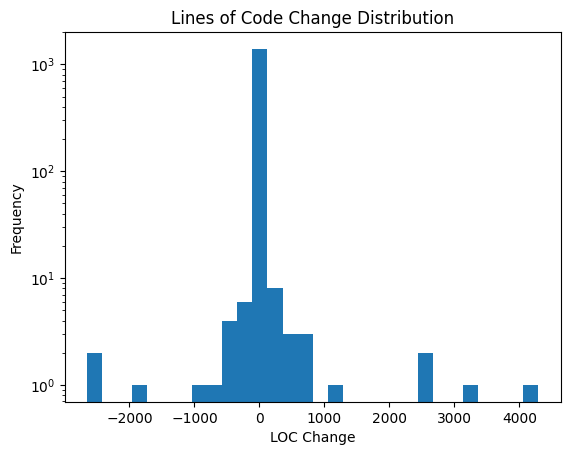

In [15]:
plt.hist(bugfix_files['MI_Change'], bins=30)
plt.title('Maintainability Index Change Distribution')
plt.xlabel('MI Change')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()
plt.hist(bugfix_files['CC_Change'], bins=30)
plt.title('Cyclomatic Complexity Change Distribution')
plt.xlabel('CC Change')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()
plt.hist(bugfix_files['LOC_Change'], bins=30)
plt.title('Lines of Code Change Distribution')
plt.xlabel('LOC Change')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

In [17]:
bugfix_files.to_csv("bugfix_commit_files_MI_CC_LOC_Added_Similarity.csv")

In [19]:
bugfix_files[['Semantic_Similarity', 'Token_Similarity']].corr()

,Semantic_Similarity,Token_Similarity
Semantic_Similarity,1.000000,0.658988
Token_Similarity,0.658988,1.000000


In [31]:
bugfix_files['Semantic_class'] = bugfix_files['Semantic_Similarity'].apply(lambda x: "Major" if x > 0.8 else "Minor")
bugfix_files['Token_class'] = bugfix_files['Token_Similarity'].apply(lambda x: "Major" if x > 0.6 else "Minor")
bugfix_files['Classes Agree'] = bugfix_files['Semantic_class'] == bugfix_files['Token_class']

In [32]:
bugfix_files['Classes Agree'].mean()

0.9671787709497207

In [33]:
bugfix_files['Semantic_class'].value_counts()

Semantic_class
Major    1400
Minor      32
Name: count, dtype: int64

In [34]:
bugfix_files['Token_class'].value_counts()

Token_class
Major    1353
Minor      79
Name: count, dtype: int64

In [35]:
bugfix_files['Classes Agree'].value_counts()

Classes Agree
True     1385
False      47
Name: count, dtype: int64

In [ ]:
bugfix_files.to_csv("bugfix_commit_files_MI_CC_LOC_Added_Similarity_Classes.csv")